# Assignment 1 - English Wikipedia page views, 2008 - 2017

#### *Ian Kirkman, 10/19/2017*

The goal of this assignment is to analyze traffic on English Wikipedia over time, and then document the process and the resulting dataset and visualization according to best practices for open research that were outlined in class.

## 1.1. Importing Libraries and Setting Parameters

This package includes the following libraries for processing and analysis:
 - `requests`: This is used to pull data from the API.
 - `json`: This is used to format, save, and load raw data from API.
 - `numpy`: This is used to build the output table as an `ndarray`.
 - `pandas`: This is used to export the output table to csv.
 - `matplotlib.pyplot`: This is used to plot the output results and save to file.
 - `datetime`: This is used to include date labels on the output plot.
 
User inputs are also set in this section, and referenced throughout the later processing steps. Inputs are split into categories of user details, universal parameters (those which apply to both the Pageviews and Pagecounts APIs), Pagecounts parameters (that differ from Pageviews), Pageviews parameters (that differ from Pagecounts), and file paths to save/access raw data imported in Section 1.2 and output locations for the table and plot.

The settings below will be used in Section 1.2 to pull all monthly Pagecounts views between January 2008 and July 2016, and all monthly Pageviews views __*excluding webcrawlers*__ between July 2015 and September 2017. Note that the date inputs are in the form **'YYYYMMDDHH'**, and the first day of the following month is chosen for the end month in order to capture all the data.

Note that the access parameters are stored as lists of strings. We need to run a separate API call for each access type in order to collect all the needed data, so our import function in Section 1.2 will iterate over each of the Pagecounts and Pageviews access lists.

The settings below also illustrate the slight schema differences between the [Legacy Pagecounts API](https://wikitech.wikimedia.org/wiki/Analytics/AQS/Legacy_Pagecounts) and the [Pageview API](https://wikitech.wikimedia.org/wiki/Analytics/AQS/Pageviews). For additional details and options, please explore the API documentation linked here.

In [1]:
%matplotlib inline

import requests
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime as dt



############ BEGIN USER INPUTS ###

github_username = 'iankirkman'
uw_email = 'ikirkman@uw.edu'
headers={'User-Agent' : 'https://github.com/%s'%github_username, 'From' : '%s'%uw_email}

# Universal Parameters
universal_params = {'project' : 'en.wikipedia.org',
                    'granularity' : 'monthly'}

# Pagecounts Parameters
pc_endpoint = 'https://wikimedia.org/api/rest_v1/metrics/legacy/pagecounts/aggregate/{project}/{access}/{granularity}/{start}/{end}'
pc_access = ['desktop-site','mobile-site'] #API Pull iterates through list
pc_month_range = ['2008010100','2016080100'] #[Start_month (YYYYMMDDHH), End_month (YYYYMMDDHH)] for API pull--
                                             #    Use the first day of the following month for End_month

# Pageviews Parameters
pv_agent = 'user' # Current API allows exclusion of crawlers
pv_endpoint = 'https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/{project}/{access}/{agent}/{granularity}/{start}/{end}'
pv_access = ['desktop','mobile-web','mobile-app'] #API Pull iterates through list
pv_month_range = ['2015070100','2017100100'] #[Start_month (YYYYMMDDHH), End_month (YYYYMMDDHH)] for API pull--
                                             #    Use the first day of the following month for End_month
    
# Filepath extensions from root project directory
raw_data_path = 'DATA'
processed_data_path = 'OUTPUT/en-wikipedia_traffic_200801-201709.csv'
output_image_path = 'OUTPUT/output_image.png'

############ END USER INPUTS ###


## 1.2. Pulling Data from the API

We have automated the raw data pull into a single function to allow for easy reproduction. The function `pull_all_from_api()` takes no arguments, but depends on the user inputs set in Section 1.1. 

The function iterates over each access type listed for Pageviews and Pagecounts in Section 1.1, building an API call and saving the json-formatted result for each iteration.

Finally, the function `pull_all_from_api()` returns a list of the raw data filenames to allow for iteration in later steps. This list is saved below as `raw_filenames`.

#### Notes and Assumptions:

 - The saved raw data is stored in the raw data directory with naming convention: `apiname_accesstype_firstmonth-lastmonth.json`. For example, the desktop views between January 2008-July 2016 from the Pagecounts API would be saved as `pagecounts_desktop-site_200801-201607.json`.

 - Note that it is assumed the user followed instructions, and included the first day of the following month for the end month paramenter in Section 1.1. The `trim_endmo` variable defined in both of the Pagecounts and Pageviews iterations of the function allow us to roll back that month to include an accurate end month in the naming convention.

In [2]:
def pull_all_from_api():
    '''
    Automated function to pull all raw data from the API into json-formatted files.
    
    DEPENDENCIES:
        - Depends on user inputs specified in Section 1.1, including endpoints, API parameters, 
          and raw data filepath location.
    
    OUTPUT:
        - Format: Raw data from the API is json-formatted.
        - Naming convention: All saved raw data files use the naming convention 
          `apiname_accesstype_firstmonth-lastmonth.json` in the raw data file location.
          
    RETURNS:
        - This funciton returns a list of the data filenames created by the call. Those
          filenames follow the naming convention: `apiname_accesstype_firstmonth-lastmonth.json`.
    '''
    # Dictionary to hold json-formatted data by name keys
    raw_jsons = {}

    # Iterate through Pagecounts access types
    for acc in pc_access:
        temp_params = {'access' : acc,
                       'start' : pc_month_range[0],
                       'end' : pc_month_range[1]}
        temp_params.update(universal_params)
        trim_endmo = (1 if pc_month_range[1][4:6] != '01' else 100) #anticipate user followed instructions for end_month
        raw_jsons['pagecounts_%s_%s-%d'%(acc,pc_month_range[0][:6],int(pc_month_range[1][:6])-trim_endmo)] = \
            requests.get(pc_endpoint.format(**temp_params)).json()

    # Iterate through Pageviews access types
    for acc in pv_access:
        temp_params = {'access' : acc,
                       'agent' : pv_agent,
                       'start' : pv_month_range[0],
                       'end' : pv_month_range[1]}
        temp_params.update(universal_params)
        trim_endmo = (1 if pv_month_range[1][4:6] != '01' else 100) #anticipate user followed instructions for end_month
        raw_jsons['pageviews_%s_%s-%d'%(acc,pv_month_range[0][:6],int(pv_month_range[1][:6])-trim_endmo)] = \
            requests.get(pv_endpoint.format(**temp_params)).json()

        
    # Output Raw API data to file
    # Reference: https://stackoverflow.com/questions/12309269/how-do-i-write-json-data-to-a-file
    for jskey in raw_jsons.keys():
        with open('%s/%s.json'%(raw_data_path,jskey), 'w') as outfile:
            json.dump(raw_jsons[jskey], outfile)
    
    # Return list of json file names for easy reference
    return [fname for fname in raw_jsons.keys()]

# Call function to write raw json data files from API calls
raw_filenames = pull_all_from_api()
raw_filenames # Show the list of saved filenames

['pagecounts_desktop-site_200801-201607',
 'pagecounts_mobile-site_200801-201607',
 'pageviews_desktop_201507-201709',
 'pageviews_mobile-web_201507-201709',
 'pageviews_mobile-app_201507-201709']

## 2.1. Processing Data

In this section, we run a script to load the raw data into a single dictionary of dictionaries, called `yearmo`. The dictionary `yearmo` has **'YYYYMM'** keys, and dictionaries with API/access-type keys and view count values. The `yearmo` dictionary is then used to construct a single output data table as a numpy array called `traffic`, with the columns/formats:

| Column | Value |
| :--- | :--- |
| year	| YYYY |
| month	| MM |
| pagecount_all_views	| num_views |
| pagecount_desktop_views	| num_views |
| pagecount_mobile_views	| num_views |
| pageview_all_views	| num_views |
| pageview_desktop_views	| num_views |
| pageview_mobile_views	| num_views |

We then use pandas to export `traffic` to a csv file, with the naming convention defined as `processed_data_path` in Section 1.1. (Note that the filename required for this assignment is **'en-wikipedia_traffic_200801-201709.csv'**).

#### Notes and Assumptions:

 - Each item in the `yearmo` dictionary that contains `mobile-app` and `mobile-web` data from the Pageviews API call will store 2 temporary keys: `pv_temp_app` and `pv_temp_web`, respectively. The values from those temporary keys are summed together into `pageview_mobile_views` when constructing the `traffic` table.
 
 - This script depends on user inputs in Section 1.1, and raw data pulled and stored in Section 1.2. It also relies on the `raw_filenames` list created at the function call `pull_all_from_api()` in Section 1.1.

 - This script exploits different naming conventions in the results schema for API calls from the [Legacy Pagecounts API](https://wikitech.wikimedia.org/wiki/Analytics/AQS/Legacy_Pagecounts) and the [Pageview API](https://wikitech.wikimedia.org/wiki/Analytics/AQS/Pageviews). For example, we know the access type `desktop-site` is from the Pagecounts API, versus the access type `desktop`, which is from the Pageviews API. 

 - The results from each API also use slightly different naming conventions, such as **'access-site'** for Pagecounts and **'access'** for Pageviews.
 
 - View counts are stored in `traffic` as integers, while year and month are stored as U25 strings.

In [3]:
# Pull raw json data into a single dictionary of with yearmo keys.
# Each value is a dictionary with counts for each data collection (source and access) type
yearmo = {}

# Note that the different access-site labels between Pageviews and Pagecounts allow for easy renaming:
rename = {'desktop-site' : 'pagecount_desktop_views',
          'mobile-site' : 'pagecount_mobile_views',
          'mobile-app' : 'pv_temp_app', # Mobile-app and mobile-web must be combined after importing
          'mobile-web' : 'pv_temp_web', # Mobile-app and mobile-web must be combined after importing
          'desktop' : 'pageview_desktop_views'}

# Read all saved raw data into yearmo dict:
for fname in raw_filenames:
    with open('%s/%s.json'%(raw_data_path,fname), 'r') as infile:
        temp_raw = json.load(infile)
    
    if fname[:9] == 'pagecount': 
        # Reading Pagecounts Data
        for item in temp_raw['items']:
            if item['timestamp'][:6] not in yearmo:
                yearmo[item['timestamp'][:6]] = {rename[item['access-site']] : item['count']}
            else: yearmo[item['timestamp'][:6]].update({rename[item['access-site']] : item['count']})
                
    else: 
        # Reading Pageviews Data
        # Note results label changes from above ('access-site' to 'access' and 'count' to 'views')
        for item in temp_raw['items']:
            if item['timestamp'][:6] not in yearmo:
                yearmo[item['timestamp'][:6]] = {rename[item['access']] : item['views']}
            else: yearmo[item['timestamp'][:6]].update({rename[item['access']] : item['views']})
        
# Use a numpy structured array for column headings in csv output
# Reference: https://stackoverflow.com/questions/5795748/store-numpy-row-and-column-headers
rows = sorted([ym for ym in yearmo.keys()])
traffic = np.zeros(len(rows),dtype=[('year','U25'),
                  ('month','U25'),
                  ('pagecount_all_views','int'),
                  ('pagecount_desktop_views','int'),
                  ('pagecount_mobile_views','int'),
                  ('pageview_all_views','int'),
                  ('pageview_desktop_views','int'),
                  ('pageview_mobile_views','int')])

# Use yearmo dict to populate numpy array 'traffic' for csv output:
for i in range(len(rows)):
    # Fill year and month strings
    traffic[i]['year'] = rows[i][:4]
    traffic[i]['month'] = rows[i][4:6]
    
    # Iterate over yearmo keys in each row to fill traffic array
    for ymkey in yearmo[rows[i]].keys():
        if ymkey[:7] != 'pv_temp': #skip temporary keys
            traffic[i][ymkey] = yearmo[rows[i]][ymkey]
            
    # Combine temporary keys for pageview mobile total
    if 'pv_temp_app' in yearmo[rows[i]].keys():
        traffic[i]['pageview_mobile_views'] = yearmo[rows[i]]['pv_temp_app'] + yearmo[rows[i]]['pv_temp_web']
        
    # Sum all views totals
    traffic[i]['pagecount_all_views'] = traffic[i]['pagecount_desktop_views'] + traffic[i]['pagecount_mobile_views']
    traffic[i]['pageview_all_views'] = traffic[i]['pageview_desktop_views'] + traffic[i]['pageview_mobile_views']
    
# Use pandas to send traffic array to csv
# Reference: https://stackoverflow.com/questions/6081008/dump-a-numpy-array-into-a-csv-file
(pd.DataFrame(traffic)).to_csv(processed_data_path)

## 3.1. Plotting the Views

In this section our goal is to produce a visual representation of the English Wikipedia page views from each API and access-type over the relevant period for each.

We define a simple function `find_plot_range(col_name)` to find the range of non-zero values in the specified column of the table `traffic`, which was constructed in our data processing script in Section 2.1.

We then run a short script to assign date formats to the year/month data, rename/format the source labels, plot each API/access views over their non-zero range, and apply some plot titles and settings.

#### Notes and Assumptions:
 - Labels starting with the word **'Legacy'** represent the Pagecounts legacy API source, whereas labels without represent the current Pageviews API source.
 
 - Labels/display names are hard-coded below, along with plot settings. They can be manually tweaked with care.
 
 - This script depends on the user inputs in Section 1.1 for the save location of the created image. It also depends on the data and schema in the numpay array `traffic`, which is created in the data processing steps of Section 2.1. See section 2.1 for further dependencies.

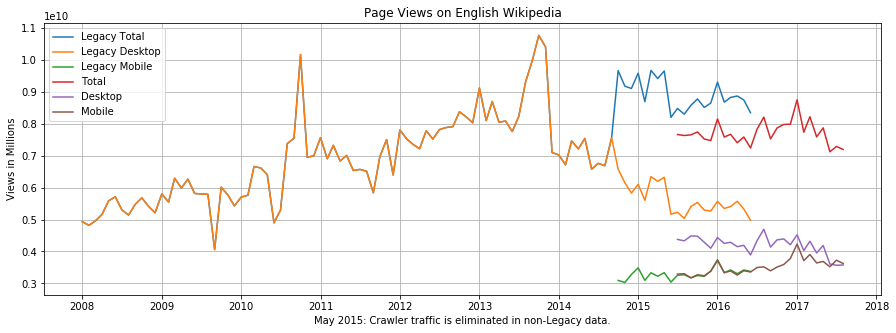

In [4]:
def find_plot_range(col_name):
    '''
    Finds the plot-able range in the specified column of the `traffic` numpy array. The plot-able 
    range is the section of values that are non-zero in the column. It is assumed that there is only
    one active range for each column (e.g.: there are no zeros in between consecutive non-zero values).
    
    INPUT:
        - The column name of `traffic` table to find a plot range for.
    
    DEPENDENCIES:
        - This function runs on the numpy array `traffic`, which was created in Section 2.1. Data and 
          schema (such as column names) for `traffic` is assumed.
        - This function assumes there is only one active range for each column (e.g.: there are no zeros 
          in between consecutive non-zero values).
          
    RETURNS:
        - This function returns a tuple range (first_index,last_index) of the first and last index
          with non-zero values for the specified column in the traffic numpy array.
    '''
    return (np.min(np.nonzero(traffic['%s'%col_name])),np.max(np.nonzero(traffic['%s'%col_name])))

# Use datetime to set x-axis labels
# Reference: https://stackoverflow.com/questions/28948898/setting-the-x-axis-as-time-years-months-for-a-set-of-values
dates = [dt.datetime(int(traffic[i]['year']),int(traffic[i]['month']),1) for i in range(len(rows))]

# Set figure size for large plot
fig, ax = plt.subplots(figsize=(15,5))

# Set Display names for columns
disp = {'pagecount_all_views' : 'Legacy Total',
        'pagecount_desktop_views' : 'Legacy Desktop',
        'pagecount_mobile_views' : 'Legacy Mobile',
        'pageview_all_views' : 'Total',
        'pageview_desktop_views' : 'Desktop',
        'pageview_mobile_views' : 'Mobile'}

# Iterate through columns to plot each one
for col in traffic.dtype.names:
    if col not in ('year','month'):
        pr = find_plot_range(col)
        plt.plot(dates[pr[0]:pr[1]],traffic[col][pr[0]:pr[1]],label=disp[col])
 
# Add some pizazz
plt.title('Page Views on English Wikipedia')
plt.ylabel('Views in Millions')
plt.xlabel('May 2015: Crawler traffic is eliminated in non-Legacy data.')
plt.legend(loc='best')

ax.grid(True)
plt.savefig(output_image_path)